In [13]:
import laspy
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [14]:
filename = "als/USGS_LPC_CA_SierraNevada_B22_10SGJ3270.laz"

In [15]:
# Read one file into memory
with laspy.open(filename) as fi:
    las = fi.read()
    print(las)

<LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 22811793 points, 1 vlrs)>


In [16]:
# Grab a subset of data
# 2_000 points gives 3ish trees
# 20_000 gives 30ish trees
n_points = 2_000

x = las.x[:n_points]
y = las.y[:n_points]
z = las.z[:n_points]

In [17]:
print(f"Making point cloud of {len(x)} points")
points = np.vstack((x, y, z)).transpose()
point_cloud = pv.PolyData(points)

Making point cloud of 2000 points


In [18]:
# Plot with PyVista
# Open the interactive 3D image to convince yourself its 3-ish trees
print(f"Plotting point cloud")
plotter = pv.Plotter()
plotter.add_mesh(point_cloud, point_size=1, render_points_as_spheres=True)
plotter.show()

Plotting point cloud


Widget(value='<iframe src="http://localhost:57930/index.html?ui=P_0x16abba510_1&reconnect=auto" class="pyvista…

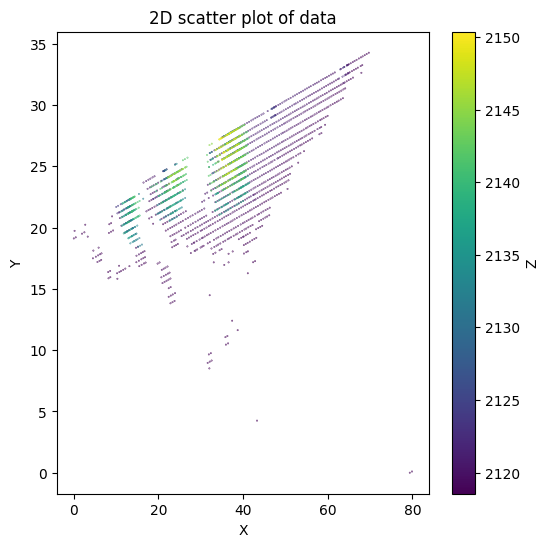

In [19]:
# Make a scatter plot of points in xy (no z)
fig, ax = plt.subplots(figsize=(6, 6))
scatter = ax.scatter(x - min(x), y - min(y), c=z, s=0.1, cmap='viridis')

# Add color bar and labels
colorbar = fig.colorbar(scatter, ax=ax, label='Z')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('2D scatter plot of data')

# Display the plot
plt.show()

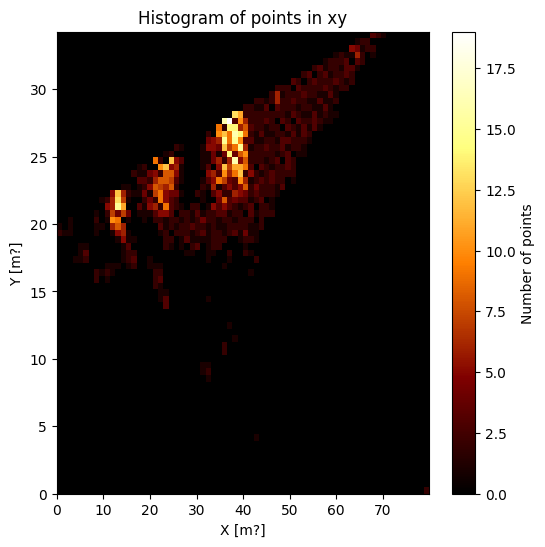

In [20]:
# Make a 2D histogram of the points in xy
# The density of points gives a hint about how many trees exist
fig, ax = plt.subplots(figsize=(6, 6))
bins = (70, 70)
hist, x_edges, y_edges, cax = ax.hist2d(x - min(x), y - min(y), cmap='afmhot', bins=bins)
colorbar = fig.colorbar(cax, ax=ax, label='Number of points')
ax.set_xlabel('X [m?]')
ax.set_ylabel('Y [m?]')
ax.set_title('Histogram of points in xy')
plt.show()

In [21]:
# Run DBSCAN on the points in xy
# The DBSCAN parameters eps, min_samples were "optimized" by hand
features = np.vstack((
    x - min(x),
    y - min(y),
)).transpose()
eps = 1
min_samples = 20
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(features)

# Get unique labels, too
unique_labels = np.unique(labels)
print(f"Unique labels:", unique_labels)

Unique labels: [-1  0  1  2  3]


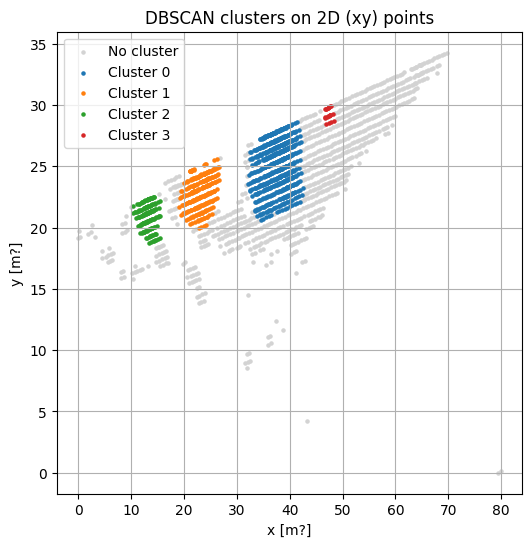

In [22]:
# Plot the DBSCAN clustering results
fig, ax = plt.subplots(figsize=(6, 6))

# Make one scatterplot per cluster
for label in unique_labels:
    no_cluster = label == -1
    cond = labels == label
    text = "No cluster" if no_cluster else f"Cluster {label}"
    color = "lightgrey" if no_cluster else None
    scatter = ax.scatter(features[:, 0][cond], features[:, 1][cond], c=color, s=5, label=text)

# Prettify
ax.set_xlabel('x [m?]')
ax.set_ylabel('y [m?]')
ax.set_title('DBSCAN clusters on 2D (xy) points')
if len(unique_labels) < 10:
    ax.legend()
ax.grid()
plt.show()

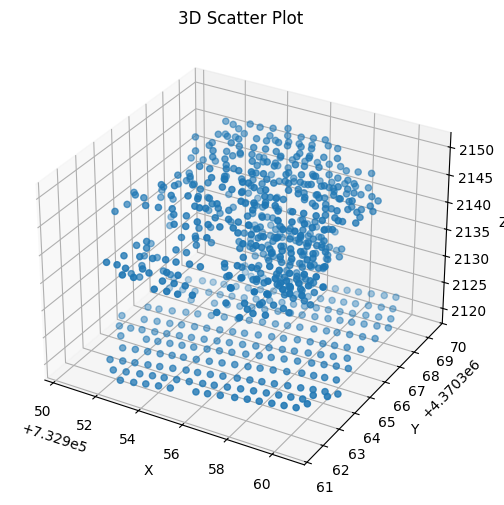

In [23]:
# Plot the first cluster in 3D
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')

# Plot the points
cond = labels == 0
sc = ax.scatter(x[cond], y[cond], z[cond], marker='o')

# Add colorbar and labels
# fig.colorbar(sc, ax=ax, label='Z Value')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Scatter Plot')
plt.show()

In [24]:
# This looks like a combination of tree points and ground points